In [104]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import load_preprocessed_data_from_folder

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.513755,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.610408,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.584737,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.482531,0.524160,0.308924,0.442628,0.504566,0.407946,0.539767,0.485483,0.599330,1.0
3992,0.371926,0.442095,0.411976,0.546609,0.596498,0.292375,0.416480,0.524698,0.460797,1.0
3993,0.471553,0.290820,0.524454,0.747456,0.432994,0.558864,0.430764,0.599290,0.580482,1.0
3994,0.483064,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


In [105]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 2955  0.493373  0.562883  0.513665     0.478480  0.557916      0.348846   
 444   0.550315  0.679033  0.356883     0.608407  0.576446      0.377569   
 2468  0.404979  0.552176  0.151445     0.661937  0.609281      0.343855   
 2865  0.652198  0.795500  0.157755     0.443050  0.633903      0.631840   
 3381  0.505938  0.791943  0.413439     0.409714  0.628996      0.472673   
 ...        ...       ...       ...          ...       ...           ...   
 2931  0.727976  0.595356  0.218518     0.483168  0.477371      0.501676   
 3034  0.499158  0.351035  0.542417     0.502540  0.587940      0.397866   
 298   0.387036  0.509064  0.584206     0.313510  0.529362      0.477454   
 1713  0.629814  0.465458  0.375206     0.499324  0.676515      0.648046   
 535   0.464546  0.420123  0.241014     0.570633  0.582629      0.587461   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 2955        0.431435 

In [106]:
# bisect the data into features and target (potability)
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [107]:
# Naive AdaBoost model

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

ada_clf = AdaBoostClassifier(algorithm='SAMME')
ada_clf.fit(train_x, train_y)

scores = cross_val_score(ada_clf, train_x, train_y, cv=NUM_FOLDS, scoring='f1')

print(f"AdaBoost score: {f1_score(test_y, ada_clf.predict(test_x)):.2%}")
# see https://scikit-learn.org/stable/modules/ensemble.html#adaboost
print(f"Cross validation scores: {scores.mean():.4f}")

AdaBoost score: 57.69%
Cross validation scores: 0.5271


In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {
  'n_estimators': [50, 100, 200],
  'learning_rate': [1.0, 2.0, 5.0, 10.0],
  'estimator': [DecisionTreeClassifier(max_depth=i) for i in (1, 5, 10, 20, 50)]
}

grid_search = GridSearchCV(
  ada_clf, 
  params, 
  scoring='f1', 
  verbose=4, 
  n_jobs=-1, 
  cv=NUM_FOLDS,
  refit=True
)
grid_search.fit(train_x, train_y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'AdaBoost F1 score: {f1_score(test_y, best_model.predict(test_x))}')
print(f'Best parameters: {best_params}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
AdaBoost F1 score: 0.7731707317073171
Best parameters: {'estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 1.0, 'n_estimators': 200}


In [109]:
# Performa a manual search to graph the F1 score agains learning_rate

from sklearn.metrics import f1_score


max_depths = range(1, 100 + 1)
scores = []

for max_depth in max_depths:
  # print(f'start: {learning_rate}')
  ada_clf = AdaBoostClassifier(
    algorithm='SAMME',
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    estimator=DecisionTreeClassifier(max_depth=max_depth),
  )
  ada_clf.fit(train_x, train_y)
  score = f1_score(test_y, ada_clf.predict(test_x))
  scores.append(score)
  # print(f'end: {learning_rate}')


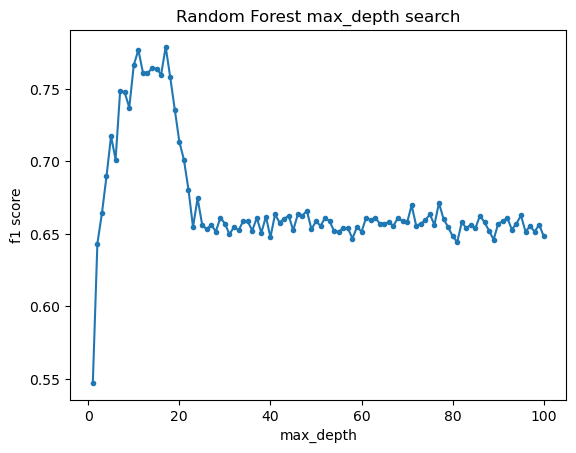

In [110]:
# Plot the search results

plt.plot(max_depths, scores)
plt.scatter(max_depths, scores, marker='.')
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.title('Random Forest max_depth search')

plt.show()

In [111]:
# Modify the best params' learning rate accordingly
BEST_MAX_DEPTH = max_depths[np.argmax(scores)]

best_model = AdaBoostClassifier(
  algorithm='SAMME',
  n_estimators=best_params['n_estimators'],
  learning_rate=best_params['learning_rate'],
  estimator=DecisionTreeClassifier(max_depth=BEST_MAX_DEPTH),
)
best_model.fit(train_x, train_y)

print(f'AdaBoost F1 score: {f1_score(test_y, best_model.predict(test_x)):0.2%}')
print(f'Best parameters: {best_params}')


AdaBoost F1 score: 77.32%
Best parameters: {'estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 1.0, 'n_estimators': 200}


In [115]:
# Try optimizing the hyperparameters with optuna
import optuna

N_TRIALS = 50

def objective(trial: optuna.Trial) -> float:
  n_estimators = trial.suggest_int('n_estimators', 50, 200)
  learning_rate = trial.suggest_int('learning_rate', 1, 20)
  max_depth = trial.suggest_int('max_depth', 1, 30)

  ada_clf = AdaBoostClassifier(
    algorithm='SAMME',
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    estimator=DecisionTreeClassifier(max_depth=max_depth),
  )

  scores = cross_val_score(ada_clf, train_x, train_y, cv=NUM_FOLDS, scoring='f1')
  return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2024-04-19 22:10:50,643] A new study created in memory with name: no-name-cb9a1715-4746-4550-b4b1-a606a53a8578
[I 2024-04-19 22:10:51,203] Trial 0 finished with value: 0.6218572237866824 and parameters: {'n_estimators': 99, 'learning_rate': 4, 'max_depth': 23}. Best is trial 0 with value: 0.6218572237866824.
[I 2024-04-19 22:10:57,814] Trial 1 finished with value: 0.6272514514661873 and parameters: {'n_estimators': 147, 'learning_rate': 1, 'max_depth': 3}. Best is trial 1 with value: 0.6272514514661873.
[I 2024-04-19 22:10:58,887] Trial 2 finished with value: 0.28924150254174763 and parameters: {'n_estimators': 53, 'learning_rate': 11, 'max_depth': 1}. Best is trial 1 with value: 0.6272514514661873.
[I 2024-04-19 22:11:18,819] Trial 3 finished with value: 0.6255424208053821 and parameters: {'n_estimators': 189, 'learning_rate': 12, 'max_depth': 9}. Best is trial 1 with value: 0.6272514514661873.
[I 2024-04-19 22:11:20,002] Trial 4 finished with value: 0.6588950538873561 and paramete